# Sales Forecasting with Confidence Interval – Retail Case Study

## Import Library

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error


## Read data

In [12]:
df = pd.read_csv("C:\Mini Proyek\sales forecast\sales_monthly_retail_case_study.csv")

df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')

# Pastikan frekuensi bulanan konsisten
df = df.asfreq('MS')


In [91]:
df.info()
pd.concat([df.head(5), df.tail(5)])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-01 to 2024-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


,sales
month,
2022-01-01,1154622475
2022-02-01,1110274560
2022-03-01,1218783865
2022-04-01,1321090100
2022-05-01,1324743373
2024-08-01,1594337792
2024-09-01,1391731935
2024-10-01,1434628611
2024-11-01,1258304021


In [75]:
df.dtypes

sales    int64
dtype: object

In [89]:
df.describe()

,sales
count,3.600000e+01
mean,1.342078e+09
std,1.341831e+08
min,1.110275e+09
25%,1.245275e+09
50%,1.322917e+09
75%,1.410604e+09
max,1.622374e+09


## Explorasi Data Analysis

In [21]:
import seaborn as sns

sns.set_color_codes("pastel")
sns.set_style("whitegrid")

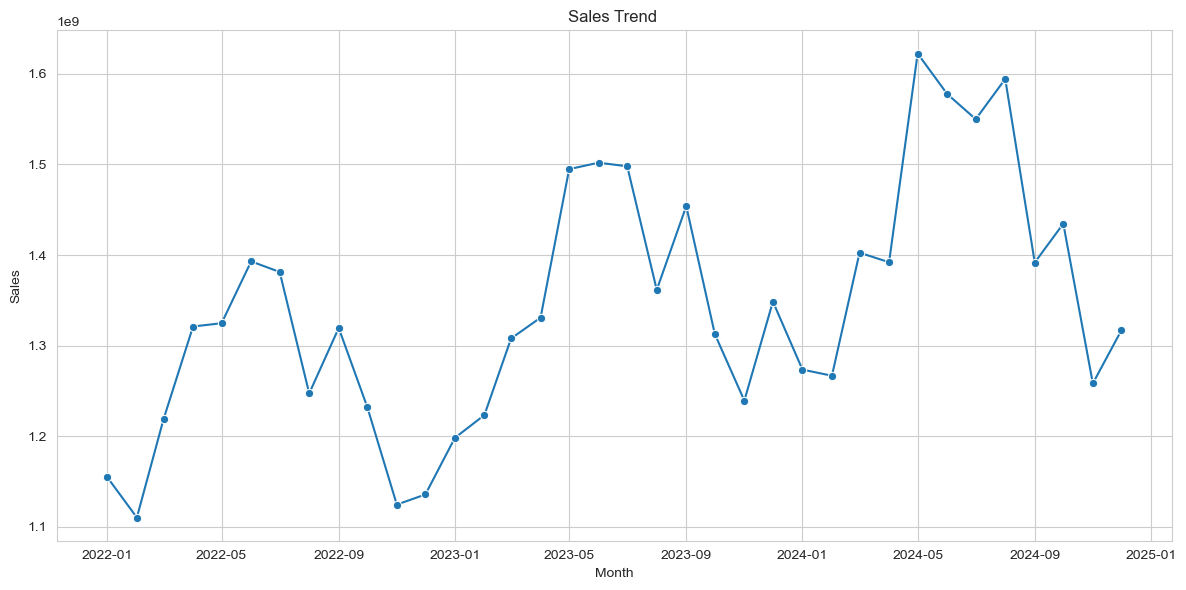

In [45]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['sales'], marker='o')
plt.title('Sales Trend ')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

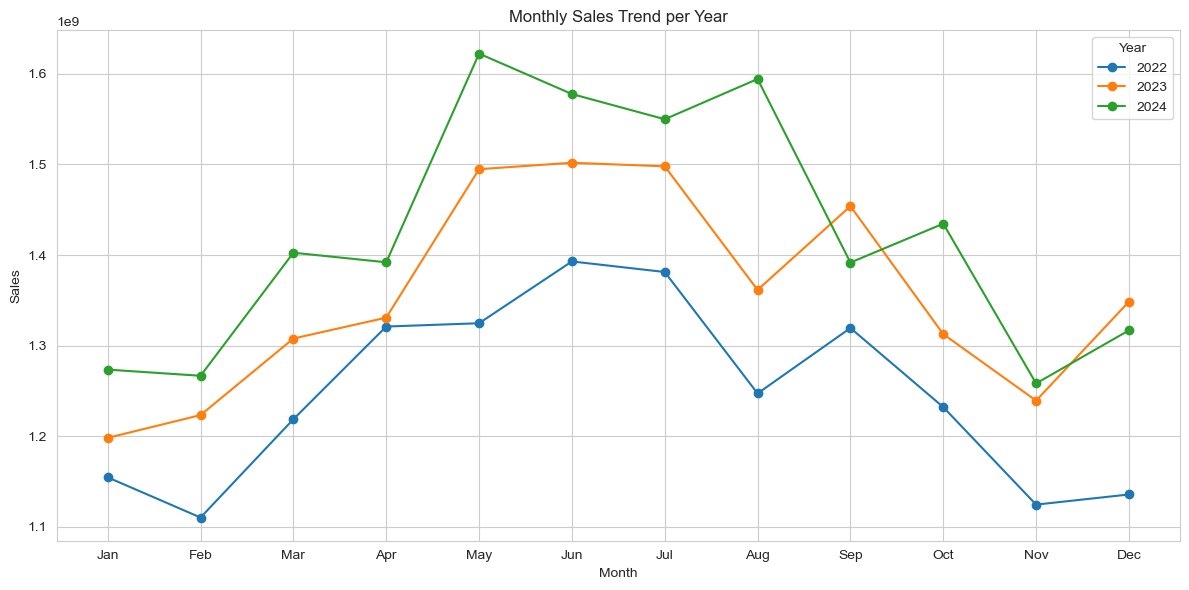

In [51]:
import calendar

plt.figure(figsize=(12, 6))
for year in df['years'].unique():
    plt.plot(
        df[df['years'] == year]['month_number'],
        df[df['years'] == year]['sales'],
        marker='o',
        label=str(year)
    )
plt.title('Monthly Sales Trend per Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)])
plt.legend(title='Year')
plt.tight_layout()
plt.show()

Key insight : Penjualan menunjukkan tren naik dengan musiman tahunan yang jelas, menjadikan Holt-Winters metode peramalan yang tepat.

##  Membangun Model Forecast (Holt-Winters)

In [55]:
# Pembagian Waktu Pelatihan dan Pengujian
train = df.iloc[:-6]
test = df.iloc[-6:]

# Membangun Model Exponential Smoothing
model = ExponentialSmoothing(
    train['sales'],
    seasonal='add',
    seasonal_periods=12,
    trend='add'
)

Model_fit = model.fit()

Key insight : Tren aditif dan musiman digunakan karena fluktuasi penjualan tetap relatif stabil seiring waktu.

## Evaluasi Model

In [69]:
pred_test = Model_fit.forecast(6)

mape = mean_absolute_percentage_error(
    test['sales'],
    pred_test
)

print(f"MAPE: {mape:.2%}")


MAPE: 4.37%


Key insight : Model ini mencapai MAPE di bawah 10%, yang dianggap cukup akurat untuk perencanaan bisnis dan peramalan.

## Forecast 12 bulan kedepan

In [80]:
forecast_12 = Model_fit.forecast(12)

## Confidence Interval Calculation

In [85]:
# Menghitung nilai fitted dan residuals
fitted = Model_fit.fittedvalues
residuals = train['sales'] - fitted

# Menghitung standar deviasi residuals
residual_std = residuals.std()

# Menghitung interval kepercayaan / confidence interval
z_score = 1.96  # 95% confidence

ci_lower = forecast_12 - z_score * residual_std
ci_upper = forecast_12 + z_score * residual_std


## Visualisasi hasil peramalan 12 bulan kedapan

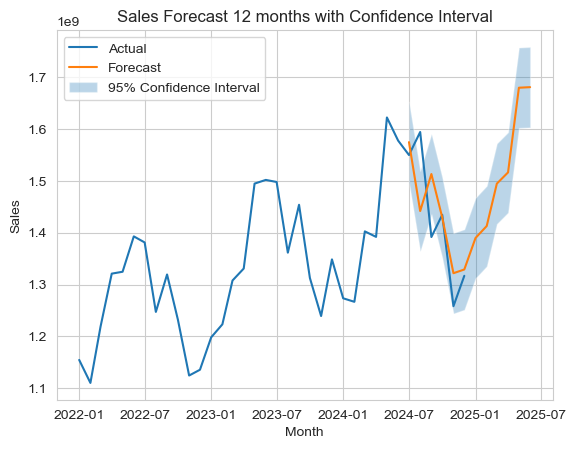

In [88]:
# Visualisasi Hasil Peramalan dengan Confidence Interval
plt.figure()
plt.plot(df.index, df['sales'], label='Actual')
plt.plot(forecast_12.index, forecast_12, label='Forecast')

plt.fill_between(
    forecast_12.index,
    ci_lower,
    ci_upper,
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Sales Forecast 12 months with Confidence Interval')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()


## Tabel forecast & CI

In [90]:
forecast_df = pd.DataFrame({
    'forecast': forecast_12.round(0),
    'ci_lower_95': ci_lower.round(0),
    'ci_upper_95': ci_upper.round(0)
})

forecast_df


,forecast,ci_lower_95,ci_upper_95
2024-07-01,1.574795e+09,1.497183e+09,1.652407e+09
2024-08-01,1.441857e+09,1.364245e+09,1.519469e+09
2024-09-01,1.513238e+09,1.435626e+09,1.590850e+09
2024-10-01,1.429445e+09,1.351833e+09,1.507057e+09
2024-11-01,1.321936e+09,1.244324e+09,1.399548e+09
2024-12-01,1.329096e+09,1.251484e+09,1.406708e+09
2025-01-01,1.389821e+09,1.312209e+09,1.467433e+09
2025-02-01,1.412957e+09,1.335345e+09,1.490569e+09
2025-03-01,1.494707e+09,1.417095e+09,1.572319e+09
2025-04-01,1.516408e+09,1.438795e+09,1.594020e+09


## Insight & Rekomendasi Bisnis

Wawasan utama :
Penjualan diperkirakan akan tumbuh secara stabil selama 12 bulan ke depan.
Puncak penjualan diperkirakan terjadi pada Q2, sejalan dengan musiman historis.
Interval kepercayaan menunjukkan ketidakpastian yang lebih tinggi pada periode puncak.

Rekomendasi Bisnis :
Tingkatkan persediaan sebelum musim puncak menggunakan batas atas interval kepercayaan.
Gunakan nilai peramalan sebagai target penjualan dasar.
Gunakan batas bawah untuk skenario perencanaan yang lebih konservatif.